# Pipeline Preprocessing Workflow

This script handles all the preprocessing of the rawdata for structural MRI and also diffusion weighted MRI
The tools used in this workflow are <b>FSL</b>, <b>FREESURFER</b> & <b>Dicom2Nii</b>

#### Handle the imports

In [1]:
from nipype import Node, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces import freesurfer, fsl
from nipype.interfaces.dcm2nii import Dcm2nii
from nipype.interfaces.io import DataFinder, DataSink
from nipype import utils as nputils

In [2]:
import numpy as np
import logging, os, shutil, re
from multiprocessing import cpu_count

#### Start the logging

In [3]:
logger = logging.getLogger('workflow')
logger.setLevel(logging.INFO)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

#### Define the later function variables in hard-code for debuging

In [4]:
#subject_folder = '/Users/srothmei/Desktop/charite/toronto/'
#subject_id = 'FR_20120903'

### Utility Nodes

In [21]:
def extractB0(dwMriFile):
    # This function is used to extract the b0 image out of the 4D series of diffusion images by splitting the
    # series, copying the first image and merging the images together into a single file afterwards
    pth, fname, ext = nputils.filemanip.split_filename(dwMriFile)
    currPth = os.path.realpath('.')

    # Change dir because FSL split takes no input for storing things somewhere else....
    os.chdir(pth)    

    splitter = fsl.utils.Split(dimension = 't', out_base_name = 'tmp_', in_file = dwMriFile)
    res = splitter.run()
    b0 = res.outputs.out_files[0]

    # Copy the b0 image and rename it accordingly
    shutil.copy(b0, 'no_diffusion.nii.gz')
    b0 = os.path.abspath('no_diffusion.nii.gz')

    # Delete the sliced files...
    for f in res.outputs.out_files:
        os.remove(f)

    # Change back into previous directory
    os.chdir(currPth)
    
    return b0

def selectFromList(inList, index):
    return inList[index]

## Set parameters and build variables

In [6]:
reconallFolderName = 'recon_all' # Define what the output folder of recon-all should be named
# Predefine some filenames
fileNames = {'wmSurf_lh': 'lh_white.nii.gz',
            'wmSurf_rh': 'rh_white.nii.gz',
            'wmSurf': 'wm_outline.nii.gz',
            'wmoutline2diff_1mm': 'wmoutline2diff_1mm.nii.gz',
            'wmoutline2diff': 'wmoutline2diff.nii.gz',
            'wmparc2diff_1mm': 'wmparc2diff_1mm.nii.gz',
            'aparc+aseg2diff_1mm': 'aparc_aseg_1mm.nii.gz',
            'aparc+aseg2diff': 'aparc_aseg2diff.nii.gz',
            'lowresWmMask': 'wmmask.nii.gz',
            'highresWmMask': 'wmmask_1mm.nii.gz',
            'bval_file': 'bvals.dat',
            'bvec_file': 'bvecs.dat',
            'dwi_file': 'dwi.nii.gz',
            'no_diffusion_image': 'lowb.nii.gz'}

def fileNameBuilder(path, fname):
    return path + fname

def pathBuilder(subject_folder, subject_id):
    subPath = subject_folder + '/' + subject_id # Build full path to subject folder
    
    def makeMyDir(dirName):
        import os
        if not os.path.exists(dirName):
            os.makedirs(dirName)
     
    #Path definitions
    dwiPreprocFolder = subPath + '/diff_processed'
    trackingFolder = subPath + '/tractography'
    calc_images = subPath + '/calc_images'
    mask_folder = trackingFolder + '/masks'
    tracks_folder = trackingFolder + '/tracks'
    
    # Make folders
    makeMyDir(dwiPreprocFolder)
    makeMyDir(trackingFolder)
    makeMyDir(calc_images)
    
    makeMyDir(mask_folder)
    makeMyDir(tracks_folder)
    
    # RawData Structure
    rawdataFolder = subPath + '/RAWDATA' # Define the path to the folder holding the rawdata dicom-files
    T1RawFolder = rawdataFolder + '/MPRAGE/' # The T1 rawdata folder
    dwiRawFolder = rawdataFolder + '/DTI' # The dwMRI rawdata folder
    fmriRawFolder = rawdataFolder + '/BOLD-EPI/' # The fMRI rawdata folder
    
    return subPath, rawdataFolder, T1RawFolder, dwiRawFolder, fmriRawFolder, dwiPreprocFolder, trackingFolder, calc_images, mask_folder, tracks_folder

pathBuildingNode = Node(Function(input_names = ['subject_folder', 'subject_id'],
                                output_names = ['subPath', 'rawdataFolder', 'T1RawFolder',
                                                'dwiRawFolder', 'fmriRawFolder', 
                                                'dwiPreprocFolder', 'trackingFolder', 'calc_images',
                                               'mask_folder', 'tracks_folder'],
                                function = pathBuilder),
                        name='pathBuilder')

### Define Inputnode and Outputnode

In [7]:
inputNode = Node(IdentityInterface(fields=['subject_id', 
                                           'subject_folder']), 
                 mandatory_inputs=True, 
                 name='input_node')


mergedOutputs = pathBuildingNode.outputs.copyable_trait_names()
mergedOutputs.extend(fileNames.keys())

outputNode = Node(IdentityInterface(fields = mergedOutputs), mandatory_inputs = False, name = 'output_node')

### Structural Data (T1) preprocessing

In [8]:
# Setup a datafinder to find the paths to the specific DICOM files
t1FinderNode = Node(DataFinder(), name = 't1Finder')
t1FinderNode.inputs.match_regex = '.*\.dcm'
#df = DataFinder(root_paths = T1RawFolder, match_regex = '.*\.dcm')
#firstFile = df.run().outputs.out_paths[0]

# Set recon-all parameters
reconallNode = Node(freesurfer.preprocess.ReconAll(), name = 'reconall')
#reconallNode.inputs.T1_files = firstFile
#reconallNode.inputs.subjects_dir = subPath
reconallNode.inputs.subject_id = reconallFolderName
reconallNode.inputs.directive = 'all'
reconallNode.inputs.openmp = cpu_count()

# Convert the T1 mgz image to nifti format for later usage
mriConverter = Node(freesurfer.preprocess.MRIConvert(), name = 'convertAparcAseg')
#convertT1.inputs.out_file = subPath + reconallFolderName + '/mri/aparc+aseg.nii.gz'
mriConverter.inputs.out_type = 'niigz'
mriConverter.inputs.out_orientation = 'RAS'

### Diffusion Data (dwMRI) preprocessing

In [9]:
# First extract the diffusion vectors and the pulse intensity (bvec and bval)
# Use dcm2nii for this task
#dwiFinderNode = t1FinderNode.clone('dwiFinder')

dcm2niiNode = Node(Dcm2nii(), name = 'dcm2niiAndBvecs')
dcm2niiNode.inputs.gzip_output = True
dcm2niiNode.inputs.date_in_filename = False
dcm2niiNode.inputs.events_in_filename = False


# Extract the first image of the DTI series i.e. the b0 image
extrctB0Node = Node(Function(input_names = ['dwMriFile'], output_names = ['b0'],
                             function = extractB0), name = 'Extract_b0')


# Perform the registration between subject T1 space and dwMRI space
bbregNode = Node(freesurfer.preprocess.BBRegister(), name = 'BBRegister')
bbregNode.inputs.init = "fsl"
bbregNode.inputs.contrast_type = "t2"
bbregNode.inputs.epi_mask = True
bbregNode.inputs.out_fsl_file = True
bbregNode.inputs.args = "--tol1d 1e-3"
bbregNode.inputs.subject_id = reconallFolderName

### Surface2Vol

In [10]:
# Transform Left Hemisphere
lhWhiteFilename = 'lh_white.nii.gz'
surf2volNode_lh = Node(freesurfer.utils.Surface2VolTransform(), name = 'surf2vol_lh')
surf2volNode_lh.inputs.hemi = 'lh'
surf2volNode_lh.inputs.mkmask = True
surf2volNode_lh.inputs.subject_id = reconallFolderName

# Transform right hemisphere
surf2volNode_rh = surf2volNode_lh.clone('surf2vol_rh')
surf2volNode_rh.inputs.hemi = 'rh'

# Merge the hemispheres
mergeHemisNode = Node(fsl.BinaryMaths(), name = 'mergeHemis')
mergeHemisNode.inputs.operation = 'add'
mergeHemisNode.inputs.output_type = 'NIFTI_GZ'

### Registration

In [11]:
# Rotate high-res (1mm) WM-border to match dwi data w/o resampling
applyReg_anat2diff_1mm = Node(freesurfer.ApplyVolTransform(), name = 'wmoutline2diff_1mm')
applyReg_anat2diff_1mm.inputs.inverse = True
applyReg_anat2diff_1mm.inputs.interp = 'nearest'
applyReg_anat2diff_1mm.inputs.no_resample = True
applyReg_anat2diff_1mm.inputs.args = '--no-save-reg'

# Rotate high-res (1mm) WM-border to match dwi data with resampling
applyReg_anat2diff = applyReg_anat2diff_1mm.clone('wmoutline2diff')
applyReg_anat2diff.inputs.no_resample = False
applyReg_anat2diff.inputs.interp = 'trilin'
# Filter out low voxels produced by trilin. interp.
thresholdNode = Node(fsl.maths.Threshold(), name = 'remove_interp_residuals')
thresholdNode.inputs.thresh = 0.1
thresholdNode.inputs.output_type = 'NIFTI_GZ'

# Binarize
binarizeNode = Node(fsl.maths.UnaryMaths(), name = 'binarize')
binarizeNode.inputs.operation = 'bin'
binarizeNode.inputs.output_type = 'NIFTI_GZ'

# Rotate high-res (1mm) wmparc to match dwi data w/o resampling
applyReg_wmparc2diff_1mm = applyReg_anat2diff_1mm.clone('wmparc2diff_1mm')

# Rotate high-res (1mm) aparc+aseg to match dwi data w/o resampling
applyReg_aparc2diff_1mm = applyReg_anat2diff_1mm.clone('aparc2diff_1mm')

# Rotate high-res (1mm) aparc+aseg to match dwi data with resampling
applyReg_aparc2diff = applyReg_anat2diff.clone('aparc2diff')
applyReg_aparc2diff.inputs.interp = 'nearest'

### Create Whitematter Brainmasks

In [12]:
def extractWhitematter(input_image, wmoutline_image, output_image):
    thresHolder = fsl.MultiImageMaths(input_file = input_image, out_file = output_image)
    thresHolder.inputs.op_string = '-uthr 41 -thr 41'
    thresHolder.run()
    
    thresHolder.inputs.input_file = output_image
    thresHolder.inputs.op_string = '-uthr 2 -thr 2'
    thresHolder.run()
    
    thresHolder.inputs.op_string = '-uthr 255 -thr 251'
    thresHolder.run()
    
    # Combine and binarize
    combinizer = fsl.BinaryMaths(operation = 'add', in_file = output_image, 
                                 operand_file = wmoutline_image, out_file = output_image)
    binarizer = fsl.UnaryMaths(operation = 'bin', in_file = output_image, out_file = output_image)
    
    return output_image

# Create the Nodes
wmmask_lowres = Node(Function(input_names = ['input_image', 'wmoutline_image', 'output_image'],
                             output_names = ['output_image'],
                             function = extractWhitematter), name = 'extract_WM_lowres')

wmmask_highres = wmmask_lowres.clone('extract_WM_highres')

### Connect the Nodes

In [17]:
wf = Workflow(name = 'preprocSub')

# Input strings to pathbuilder
wf.connect([(inputNode, pathBuildingNode, [('subject_id', 'subject_id'),
                                          ('subject_folder', 'subject_folder')])])
# T1-Rawdata-path into dataFinder to find T1 DICOMs
wf.connect(pathBuildingNode, 'T1RawFolder', t1FinderNode, 'root_paths')
# T1 DICOM-paths into recon_all
wf.connect(t1FinderNode, 'out_paths', reconallNode, 'T1_files')
# Subject path into recon-all
wf.connect(pathBuildingNode, 'subPath', reconallNode, 'subjects_dir')

# aparc+aseg into mriConverter
wf.connect([(reconallNode, mriConverter, [(('aparc_aseg', selectFromList, 0) , 'in_file')])])

# dcm2nii
wf.connect([(pathBuildingNode, dcm2niiNode, [('dwiRawFolder', 'source_dir'),
                                            ('dwiPreprocFolder', 'output_dir')])])
# B0 extraction
wf.connect(dcm2niiNode, 'converted_files', extrctB0Node, 'dwMriFile')

# Register b0 into T1 space
wf.connect([(extrctB0Node, bbregNode, [('b0', 'source_file')]),
           (pathBuildingNode, bbregNode, [('subPath', 'subjects_dir')])])

# Tranform lh whitematter surface to voxel-space
wf.connect([(pathBuildingNode, surf2volNode_lh, [('subPath', 'subjects_dir'),
                                                (('calc_images', fileNameBuilder, fileNames['wmSurf_lh']),
                                                 'transformed_file')]),
           (reconallNode, surf2volNode_lh, [('T1', 'template_file')])])
# Tranform rh whitematter...
wf.connect([(pathBuildingNode, surf2volNode_rh, [('subPath', 'subjects_dir'),
                                                (('calc_images', fileNameBuilder, fileNames['wmSurf_rh']),
                                                 'transformed_file')]),
           (reconallNode, surf2volNode_rh, [('T1', 'template_file')])])

# Merge the hemispheres
wf.connect([(surf2volNode_lh, mergeHemisNode, [('transformed_file', 'in_file')]),
           (surf2volNode_rh, mergeHemisNode, [('transformed_file', 'operand_file')]),
           (pathBuildingNode, mergeHemisNode, [(('calc_images', fileNameBuilder, fileNames['wmSurf']), 'out_file')])])

# Registrations --__--__--__--
wf.connect([(extrctB0Node, applyReg_anat2diff_1mm, [('b0', 'source_file')]),
           (mergeHemisNode, applyReg_anat2diff_1mm, [('out_file', 'target_file')]),
           (bbregNode, applyReg_anat2diff_1mm, [('out_reg_file', 'reg_file')]),
           (pathBuildingNode, applyReg_anat2diff_1mm,
            [(('calc_images',fileNameBuilder ,fileNames['wmoutline2diff_1mm']), 'transformed_file')])])

wf.connect([(extrctB0Node, applyReg_anat2diff, [('b0', 'source_file')]),
           (mergeHemisNode, applyReg_anat2diff, [('out_file', 'target_file')]),
           (bbregNode, applyReg_anat2diff, [('out_reg_file', 'reg_file')]),
           (pathBuildingNode, applyReg_anat2diff,
            [(('calc_images',fileNameBuilder ,fileNames['wmoutline2diff']), 'transformed_file')])])

wf.connect([(applyReg_anat2diff, thresholdNode, [('transformed_file', 'in_file'),
                                                ('transformed_file', 'out_file')])])
wf.connect([(thresholdNode, binarizeNode, [('out_file', 'in_file'),
                                          ('out_file', 'out_file')])])

wf.connect([(extrctB0Node, applyReg_wmparc2diff_1mm, [('b0', 'source_file')]),
           (reconallNode, applyReg_wmparc2diff_1mm, [('wmparc', 'target_file')]),
           (bbregNode, applyReg_wmparc2diff_1mm, [('out_reg_file', 'reg_file')]),
           (pathBuildingNode, applyReg_wmparc2diff_1mm,
            [(('calc_images',fileNameBuilder ,fileNames['wmparc2diff_1mm']), 'transformed_file')])])

wf.connect([(extrctB0Node, applyReg_aparc2diff_1mm, [('b0', 'source_file')]),
           (reconallNode, applyReg_aparc2diff_1mm, [('aparc_aseg', 'target_file')]),
           (bbregNode, applyReg_aparc2diff_1mm, [('out_reg_file', 'reg_file')]),
           (pathBuildingNode, applyReg_aparc2diff_1mm,
            [(('calc_images',fileNameBuilder ,fileNames['aparc+aseg2diff_1mm']), 'transformed_file')])])

wf.connect([(extrctB0Node, applyReg_aparc2diff, [('b0', 'source_file')]),
           (reconallNode, applyReg_aparc2diff, [('aparc_aseg', 'target_file')]),
           (bbregNode, applyReg_aparc2diff, [('out_reg_file', 'reg_file')]),
           (pathBuildingNode, applyReg_aparc2diff,
            [(('calc_images',fileNameBuilder ,fileNames['aparc+aseg2diff']), 'transformed_file')])])

# Mask creation
wf.connect([(applyReg_aparc2diff, wmmask_lowres, [('transformed_file', 'input_image')]),
           (mergeHemisNode, wmmask_lowres, [('out_file', 'wmoutline_image')]),
           (pathBuildingNode, wmmask_lowres, [(('calc_images', fileNameBuilder, fileNames['lowresWmMask']),
                                               'output_image')])])

wf.connect([(applyReg_aparc2diff_1mm, wmmask_highres, [('transformed_file', 'input_image')]),
           (mergeHemisNode, wmmask_highres, [('out_file', 'wmoutline_image')]),
           (pathBuildingNode, wmmask_highres, [(('calc_images', fileNameBuilder, fileNames['highresWmMask']),
                                               'output_image')])])

# Now forwards all relevant stuff to output node
for i in pathBuildingNode.outputs.copyable_trait_names():
    wf.connect([(pathBuildingNode, outputNode, [(i, i)])])
    
wf.connect([(wmmask_highres, outputNode, [('output_image', fileNames['highresWmMask'])]),
           (wmmask_lowres, outputNode, [('output_image', fileNames['lowresWmMask'])]),
           (applyReg_aparc2diff, outputNode, [('transformed_file', fileNames['aparc+aseg2diff'])]),
           (applyReg_aparc2diff_1mm, outputNode, [('transformed_file', fileNames['aparc+aseg2diff_1mm'])]),
           (mergeHemisNode, outputNode, [('out_file', fileNames['wmSurf'])]),
           (applyReg_anat2diff_1mm, outputNode, [('transformed_file', fileNames['wmoutline2diff_1mm'])]),
           (applyReg_anat2diff, outputNode, [('transformed_file', fileNames['wmoutline2diff'])]),
           (applyReg_wmparc2diff_1mm, outputNode, [('transformed_file', fileNames['wmparc2diff_1mm'])]),
            (dcm2niiNode, outputNode, [('bvals', 'bval_file'),
                                      ('bvecs', 'bvec_file')]),
            (extrctB0Node, outputNode, [('b0', 'no_diffusion_image')]),
            (dcm2niiNode, outputNode, [('converted_files', 'dwi_file')])
           ])

2015-11-26 14:16:36,864 - INFO - Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot to png format
INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot to png format


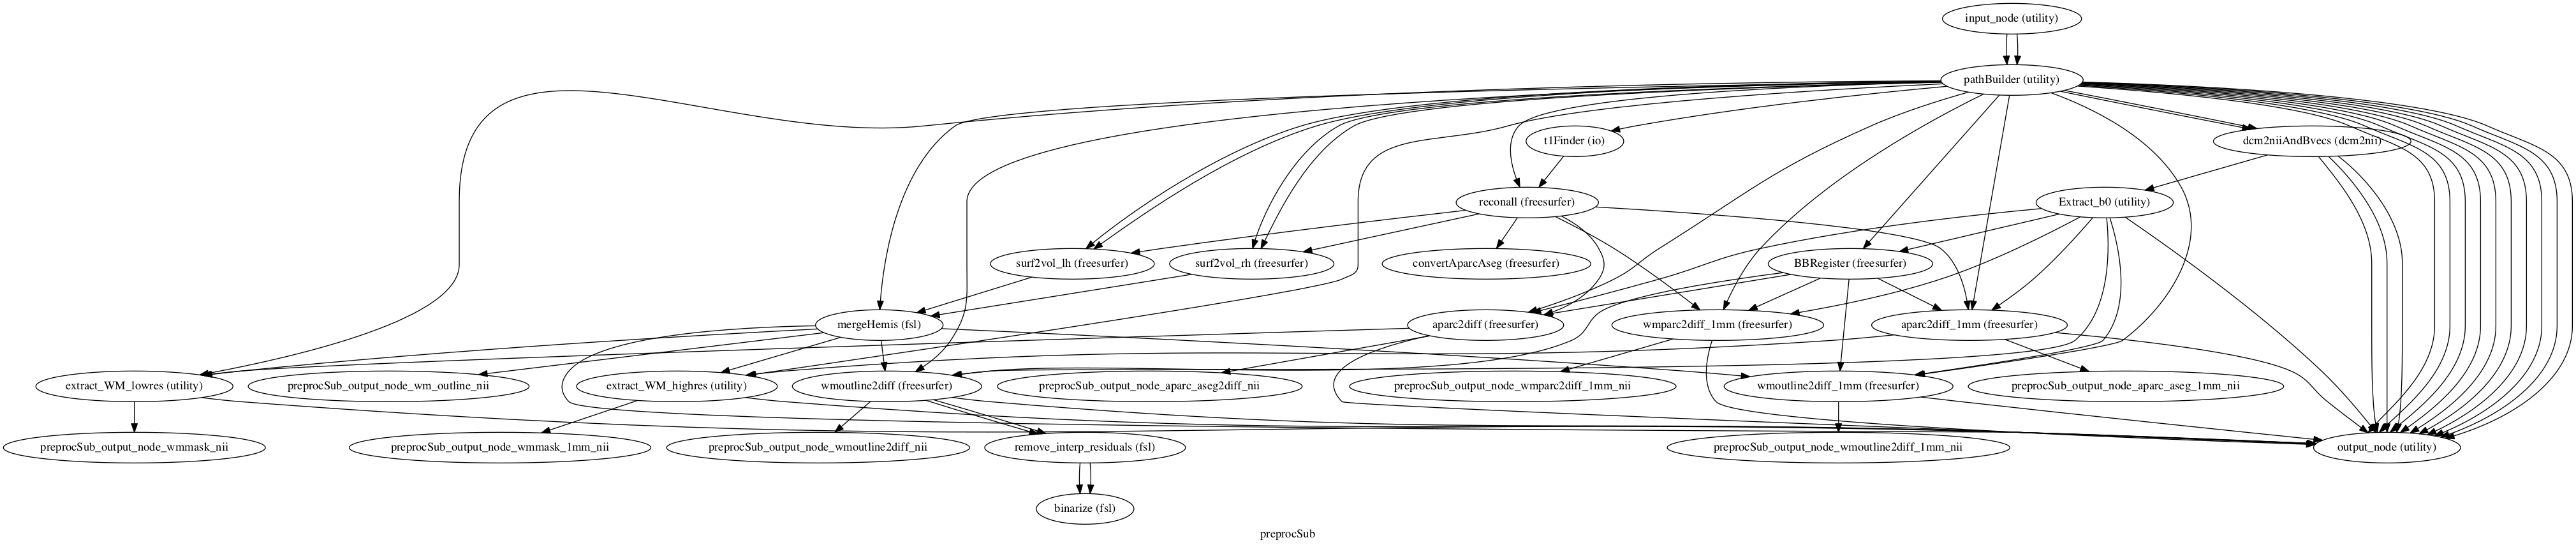

In [18]:
#wf.write_graph("workflow_graph.dot")
#from IPython.display import Image
#Image(filename="workflow_graph.dot.png")